# Notebook structure
The main idea here is to analyze predictive power of several alpha factors using alphalens. The data comes from free Quantopian datasets

- In the first part, we want to check if well known market anomalies have predictive power for future stock returns.
- In the second part, we will look on some hand crafted features that we chose during the resarch
- In the third part, we will introduce factor based on surprise - "expectation vs reality" difference
- In the last part, we will compare factors that have a high predictive power and look on the group neutral strategies

We fixed start and end range for all approaches in order to have a possibility to compare their results fairly

In [109]:
from quantopian.pipeline.data.sentdex import sentiment

from quantopian.pipeline import Pipeline
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline

from quantopian.pipeline.filters import QTradableStocksUS
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, Returns
from quantopian.pipeline.data.morningstar import Fundamentals
from alphalens.performance import mean_information_coefficient
from alphalens.tears import create_returns_tear_sheet
from quantopian.pipeline.data.factset.estimates import PeriodicConsensus, Actuals
 

import numpy as np
import matplotlib.pyplot as plt 

## Well known market anomalies

- SizeEffect: Smaller stocks typically outperform larger stocks,especially in January
- ValueEffect: Low P/B (value) stocks typically outperformhigh P/B (growth) stocks
- Momentum: Stocks with high returns over the past 12 monthstypically continue to outperform stocks with low past returns

The idea of this part is to look on their predictive power for fixedd period using alphalens

In [2]:
class MomentumM(CustomFactor):
    # will give us the returns from last month
    inputs = [Returns(window_length=20)]
    window_length = 20
    
    def compute(self, today, assets, out, lag_returns):
        out[:] = lag_returns[0]
        
class MomentumQ(CustomFactor):
    # will give us the returns from last quarter
    inputs = [Returns(window_length=63)]
    window_length = 63
    
    def compute(self, today, assets, out, lag_returns):
        out[:] = lag_returns[0]
        
class MomentumY(CustomFactor):
    # will give us the returns from last year
    inputs = [Returns(window_length=252)]
    window_length = 252
    
    def compute(self, today, assets, out, lag_returns):
        out[:] = lag_returns[0]

def make_pipeline():
    
    market_cap = Fundamentals.market_cap.latest
    price_to_book = Fundamentals.pb_ratio.latest
    momentum_month = MomentumM()
    momentum_quarter = MomentumQ()
    momentum_year = MomentumY()
    
    combined_factor_0 = (market_cap.zscore() + price_to_book.zscore())/2
    combined_factor_1 = (market_cap.zscore() + price_to_book.zscore() + momentum_month.zscore())/3
    combined_factor_2 = (market_cap.zscore() + price_to_book.zscore() + momentum_quarter.zscore())/3
    combined_factor_3 = (market_cap.zscore() + price_to_book.zscore() + momentum_year.zscore())/3
    
    #"value_score = Fundamentals.value_score.latest

    # Add the factor to the pipeline.
    return Pipeline(
        columns={
            'market_cap': market_cap,
            'price_to_book': price_to_book,
            'momentum_month': momentum_month,
            'momentum_quarter': momentum_quarter,
            'momentum_year': momentum_year,
            'combined_factor_0': combined_factor_0,
            'combined_factor_1': combined_factor_1,
            'combined_factor_2': combined_factor_2,
            'combined_factor_3': combined_factor_3
        },
        #domain=US_EQUITIES,
        screen=QTradableStocksUS() 
    )

In [3]:
# Run the pipeline over a year and print the result.
factor_data = run_pipeline(make_pipeline(), '2016-05-05', '2018-05-05')
factor_data.head()

combined_factor_0  \
2016-05-05 00:00:00+00:00 Equity(2 [HWM])             0.116006   
                          Equity(24 [AAPL])           9.797403   
                          Equity(31 [ABAX])          -0.121812   
                          Equity(39 [DDC])           -0.125124   
                          Equity(41 [ARCB])          -0.135221   

                                             combined_factor_1  \
2016-05-05 00:00:00+00:00 Equity(2 [HWM])             0.002818   
                          Equity(24 [AAPL])           6.632763   
                          Equity(31 [ABAX])          -0.018840   
                          Equity(39 [DDC])           -0.297468   
                          Equity(41 [ARCB])          -0.299440   

                                             combined_factor_2  \
2016-05-05 00:00:00+00:00 Equity(2 [HWM])             0.087597   
                          Equity(24 [AAPL])           6.418046   
                          Equity(31 [ABAX])          -0.203202   
                          Equity(39 [DDC])            0.121501   
                          Equity(41 [ARCB])          -0.338755   

                                             combined_factor_3    market_cap  \
2016-05-05 00:00:00+00:00 Equity(2 [HWM])             0.063813  1.346402e+10   
                          Equity(24 [AAPL])           6.758280  5.159187e+11   
                          Equity(31 [ABAX])           0.050617  1.004852e+09   
                          Equity(39 [DDC])            0.199485  9.608831e+08   
                          Equity(41 [ARCB])          -0.175538  4.370488e+08   

                                             momentum_month  momentum_quarter  \
2016-05-05 00:00:00+00:00 Equity(2 [HWM])         -0.012088         -0.111725   
                          Equity(24 [AAPL])        0.072749         -0.200558   
                          Equity(31 [ABAX])        0.054015         -0.206612   
                          Equity(39 [DDC])        -0.079470          0.027933   
                          Equity(41 [ARCB])       -0.077172         -0.297452   

                                             momentum_year  price_to_book  
2016-05-05 00:00:00+00:00 Equity(2 [HWM])         0.037238       1.123125  
                          Equity(24 [AAPL])       0.506276       3.954703  
                          Equity(31 [ABAX])       0.321059       4.184111  
                          Equity(39 [DDC])        0.616061       0.750381  
                          Equity(41 [ARCB])      -0.103093       0.742361

In [4]:
pricing_data = get_pricing(factor_data.index.levels[1], '2016-05-05', '2019-05-05', fields='open_price')

In [9]:
longest_look_forward_period = 252 # week = 5, month = 21, quarter = 63, year = 252
range_step = 20

factor_names = ['market_cap', 'price_to_book', 'momentum_month', 'momentum_quarter', 
               'momentum_year', 'combined_factor_0', 'combined_factor_1',
               'combined_factor_2', 'combined_factor_3']

factor_merged_data_list = []

for factor_name in factor_names:
    
    print("Computing forward returns for: ", factor_name, '\n')
    
    factor_merged_data = get_clean_factor_and_forward_returns(
        factor_data[factor_name], # How to analyze a specific pipeline column with Alphalens
        pricing_data, 
        periods=range(1,longest_look_forward_period,range_step))
    
    factor_merged_data_list.append(factor_merged_data)

Computing forward returns for:  market_cap
Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  price_to_book
Dropped 5.3% entries from factor data: 5.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  momentum_month
Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  momentum_quarter
Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns f

In [11]:
mean_ic_list = []

for factor_name, factor_merged_data in zip(factor_names, factor_merged_data_list):
    
    print('Computing mean IC for: ' + factor_name)
    factor_mean_information_coefficient = mean_information_coefficient(factor_merged_data)
    mean_ic_list.append(factor_mean_information_coefficient.values)

inds = range(1,longest_look_forward_period,range_step)

Computing mean IC for: market_cap
Computing mean IC for: price_to_book
Computing mean IC for: momentum_month
Computing mean IC for: momentum_quarter
Computing mean IC for: momentum_year
Computing mean IC for: combined_factor_0
Computing mean IC for: combined_factor_1
Computing mean IC for: combined_factor_2
Computing mean IC for: combined_factor_3


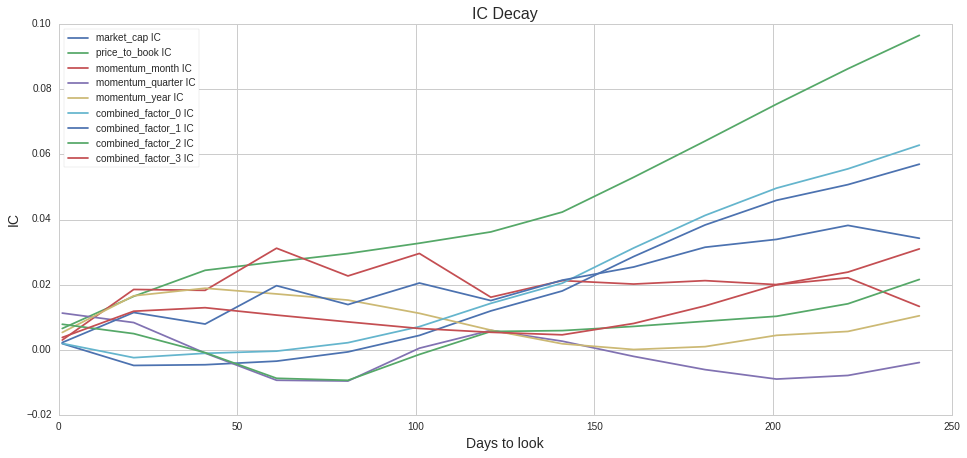

In [14]:
plt.figure(figsize=(16, 7))

for factor_name, factor_mean_ic in zip(factor_names, mean_ic_list):
    plt.plot(inds, factor_mean_ic, label=factor_name + ' IC')
    

plt.legend(loc='upper left')
plt.xlabel("Days to look", size=14)
plt.ylabel('IC', size=14)
plt.title('IC Decay', size=16)
plt.show();

A rule of dumb says, that if factor has a positive IC mean, it is worth to investigate. As we have a great number of plots corresponding to each factor, we will enter them manually through key index

In [34]:
# momentum_month, momentum_quarter, combined_factor_2

key = 8

factor_merged_data = factor_merged_data_list[key]
print('Factor ', factor_names[key])

Factor  combined_factor_3


Returns Analysis


1D    21D    41D    61D  \
Ann. alpha                                     0.026  0.037  0.037  0.042   
beta                                          -0.140 -0.191 -0.209 -0.257   
Mean Period Wise Return Top Quantile (bps)     0.299  0.330  0.290  0.104   
Mean Period Wise Return Bottom Quantile (bps)  0.569  0.458  0.503  0.387   
Mean Period Wise Spread (bps)                 -0.271 -0.104 -0.196 -0.262   

                                                 81D   101D   121D   141D  \
Ann. alpha                                     0.050  0.057  0.057  0.047   
beta                                          -0.305 -0.353 -0.371 -0.323   
Mean Period Wise Return Top Quantile (bps)    -0.060 -0.161 -0.283 -0.407   
Mean Period Wise Return Bottom Quantile (bps)  0.143  0.150  0.135  0.069   
Mean Period Wise Spread (bps)                 -0.186 -0.296 -0.403 -0.454   

                                                161D   181D   201D   221D  \
Ann. alpha                                     0.021  0.010  0.005  0.002   
beta                                          -0.147 -0.052  0.017  0.060   
Mean Period Wise Return Top Quantile (bps)    -0.353 -0.310 -0.192 -0.083   
Mean Period Wise Return Bottom Quantile (bps) -0.152 -0.336 -0.523 -0.609   
Mean Period Wise Spread (bps)                 -0.183  0.042  0.345  0.542   

                                                241D  
Ann. alpha                                     0.006  
beta                                           0.051  
Mean Period Wise Return Top Quantile (bps)     0.065  
Mean Period Wise Return Bottom Quantile (bps) -0.733  
Mean Period Wise Spread (bps)                  0.814

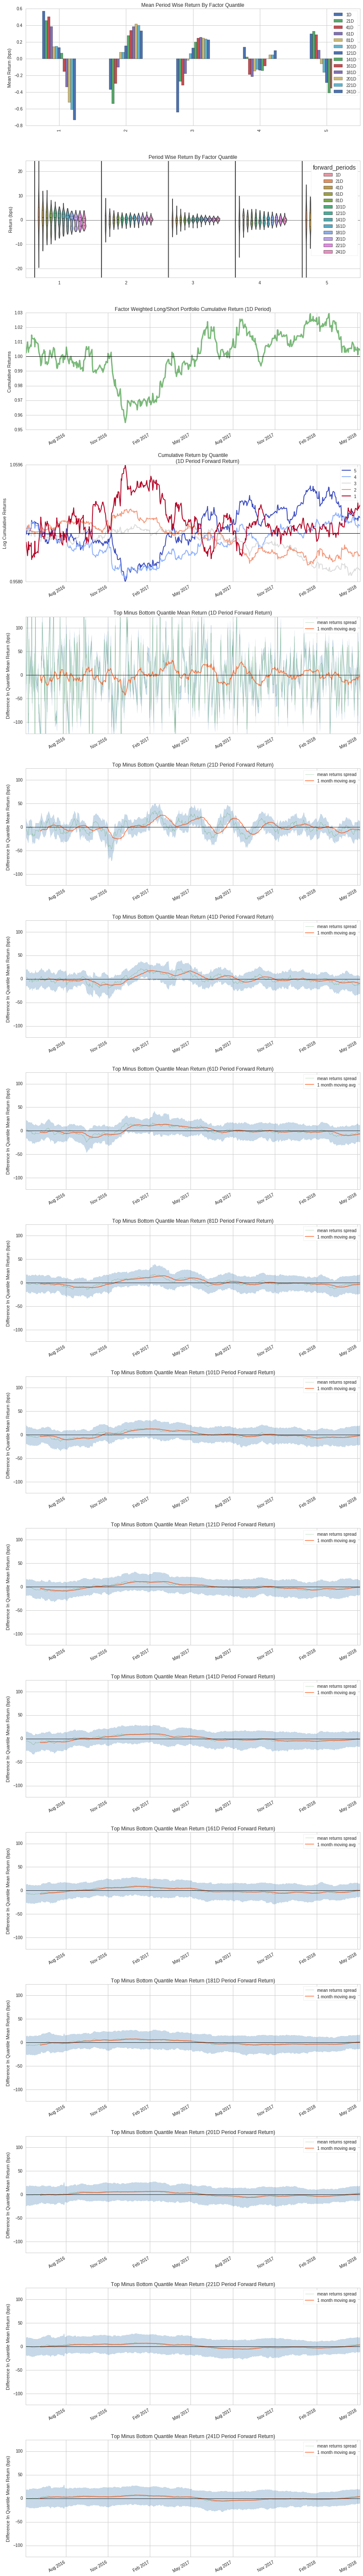

In [32]:
create_returns_tear_sheet(factor_merged_data)

Agein, we were interested which factors have the most predictive power in terms of information coficient. We also looked on 'Mean Period wise Return By Factor Quantile' and 'Cumulative Return by Quantile' (both 1D period forward return). We can see if factor quantiles perform in expected way (not many quantiles lines crossings and more importantly 1st quantile should have the lowest returns and 5st quantile - the highest one)

So the best perfoming one for period ('2016-05-05', '2018-05-05') are momentum_month, momentum_quarter, combined_factor_2.

We will look on them later.

### Quantopian API has kind of united scores for value and size factors. Lets look on them with the same approach
 
A high value score indicates that a stock’s price is relatively low, given the anticipated per-sharing earnings, book value, revenues, cash flow, and dividends that the stock provides to investors. A high price relative to these measures indicates that a stock’s value orientation is weak, but it does not necessarily mean that the stock is growth-oriented.

The investment size indicator which serves as the Y-axis value of the Morningstar Style Box. Stocks are given a score based the cumulative market capitalization of its style zone. Morningstar calculates this figure in-house monthly based on data form the past five years.

The investment style indicator which serves as X-axis value of the Morningstar Style Box. Stocks are given a value score based on five fundamental measures and a growth score based on five growth rates. Stocks are scored against their style zone and size peers. The difference between the stock’s growth and value scores is the net style score. Morningstar calculates this figure in-house monthly based on data form the past five years.


In [101]:
def make_pipeline():
    
    value_score = Fundamentals.value_score.latest
    size_score = Fundamentals.size_score.latest
    style_score = Fundamentals.style_score.latest
    
    value_style_scores = (value_score.zscore() + style_score.zscore())/2
    value_size_scores = (value_score.zscore() + size_score.zscore())/2
    
    size_style_scores = (style_score.zscore() + size_score.zscore())/2
    
    
    value_style_and_size_scores = (value_score.zscore() + size_score.zscore() + style_score.zscore())/3
    
    return Pipeline(
        columns={
            'value_score': value_score,
            'size_score': size_score,
            'style_score': style_score,
            'value_style_scores': value_style_scores,
            'value_size_scores': value_size_scores,
            'size_style_scores': size_style_scores,
            'value_style_and_size_scores': value_style_and_size_scores
        },
        screen=QTradableStocksUS() 
    )


In [102]:
# Run the pipeline over a year and print the result.
factor_data = run_pipeline(make_pipeline(), '2016-05-05', '2018-05-05')

In [103]:
pricing_data = get_pricing(factor_data.index.levels[1], '2016-05-05', '2019-05-05', fields='open_price')

In [104]:
longest_look_forward_period = 252 # week = 5, month = 21, quarter = 63, year = 252
range_step = 20

factor_names = ['value_score', 'size_score', 'style_score', 'value_style_scores',
                'value_size_scores', 'size_style_scores', 'value_style_and_size_scores']

factor_merged_data_list = []

for factor_name in factor_names:
    
    print("Computing forward returns for: ", factor_name, '\n')
    
    factor_merged_data = get_clean_factor_and_forward_returns(
        factor_data[factor_name], # How to analyze a specific pipeline column with Alphalens
        pricing_data, 
        periods=range(1,longest_look_forward_period,range_step))
    
    factor_merged_data_list.append(factor_merged_data)

Computing forward returns for:  value_score 

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  size_score 

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  style_score 

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  value_style_scores 

Dropped 7.4% entries from factor data: 7.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward retu

In [105]:
mean_ic_list = []

for factor_name, factor_merged_data in zip(factor_names, factor_merged_data_list):
    
    print('Computing mean IC for: ' + factor_name)
    factor_mean_information_coefficient = mean_information_coefficient(factor_merged_data)
    mean_ic_list.append(factor_mean_information_coefficient.values)

inds = range(1,longest_look_forward_period,range_step)

Computing mean IC for: value_score
Computing mean IC for: size_score
Computing mean IC for: style_score
Computing mean IC for: value_style_scores
Computing mean IC for: value_size_scores
Computing mean IC for: size_style_scores
Computing mean IC for: value_style_and_size_scores


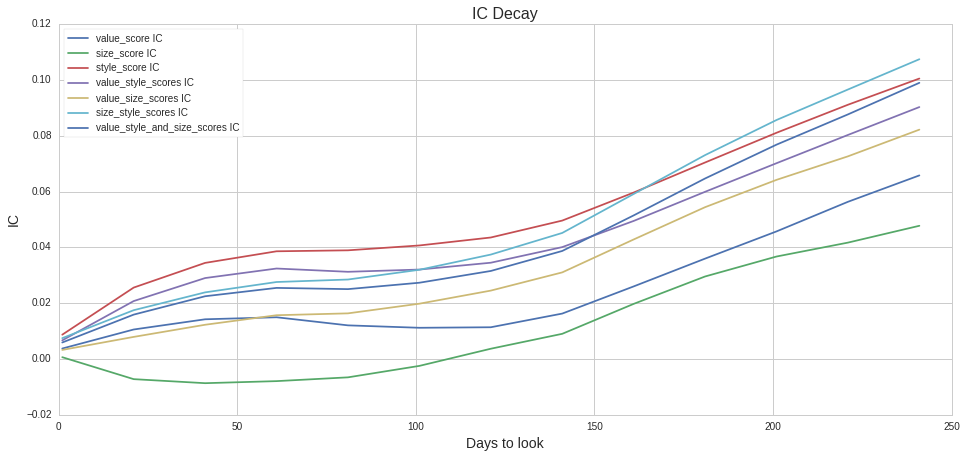

In [106]:
plt.figure(figsize=(16, 7))

for factor_name, factor_mean_ic in zip(factor_names, mean_ic_list):
    plt.plot(inds, factor_mean_ic, label=factor_name + ' IC')
    

plt.legend(loc='upper left')
plt.xlabel("Days to look", size=14)
plt.ylabel('IC', size=14)
plt.title('IC Decay', size=16)
plt.show();

In [99]:
# style_score, value_style_scores
key = 1
factor_merged_data = factor_merged_data_list[key]
print('Factor ', factor_names[key])

Factor  size_score


Returns Analysis


1D    21D    41D    61D  \
Ann. alpha                                    -0.064 -0.017 -0.024 -0.013   
beta                                           0.016  0.013  0.093 -0.132   
Mean Period Wise Return Top Quantile (bps)     1.111  1.203  1.147  1.045   
Mean Period Wise Return Bottom Quantile (bps)  0.230  0.351  0.377  0.517   
Mean Period Wise Spread (bps)                  0.881  0.825  0.752  0.517   

                                                 81D   101D   121D   141D  \
Ann. alpha                                    -0.027 -0.057 -0.023 -0.066   
beta                                          -0.174  0.036 -0.182  0.143   
Mean Period Wise Return Top Quantile (bps)     0.946  0.814  0.697  0.617   
Mean Period Wise Return Bottom Quantile (bps)  0.553  0.594  0.636  0.637   
Mean Period Wise Spread (bps)                  0.383  0.214  0.056 -0.027   

                                                161D   181D   201D   221D  \
Ann. alpha                                    -0.049 -0.036 -0.062 -0.048   
beta                                           0.105  0.076  0.309  0.256   
Mean Period Wise Return Top Quantile (bps)     0.492  0.451  0.438  0.413   
Mean Period Wise Return Bottom Quantile (bps)  0.585  0.527  0.442  0.387   
Mean Period Wise Spread (bps)                 -0.101 -0.085 -0.010  0.021   

                                                241D  
Ann. alpha                                    -0.016  
beta                                           0.016  
Mean Period Wise Return Top Quantile (bps)     0.378  
Mean Period Wise Return Bottom Quantile (bps)  0.359  
Mean Period Wise Spread (bps)                  0.017

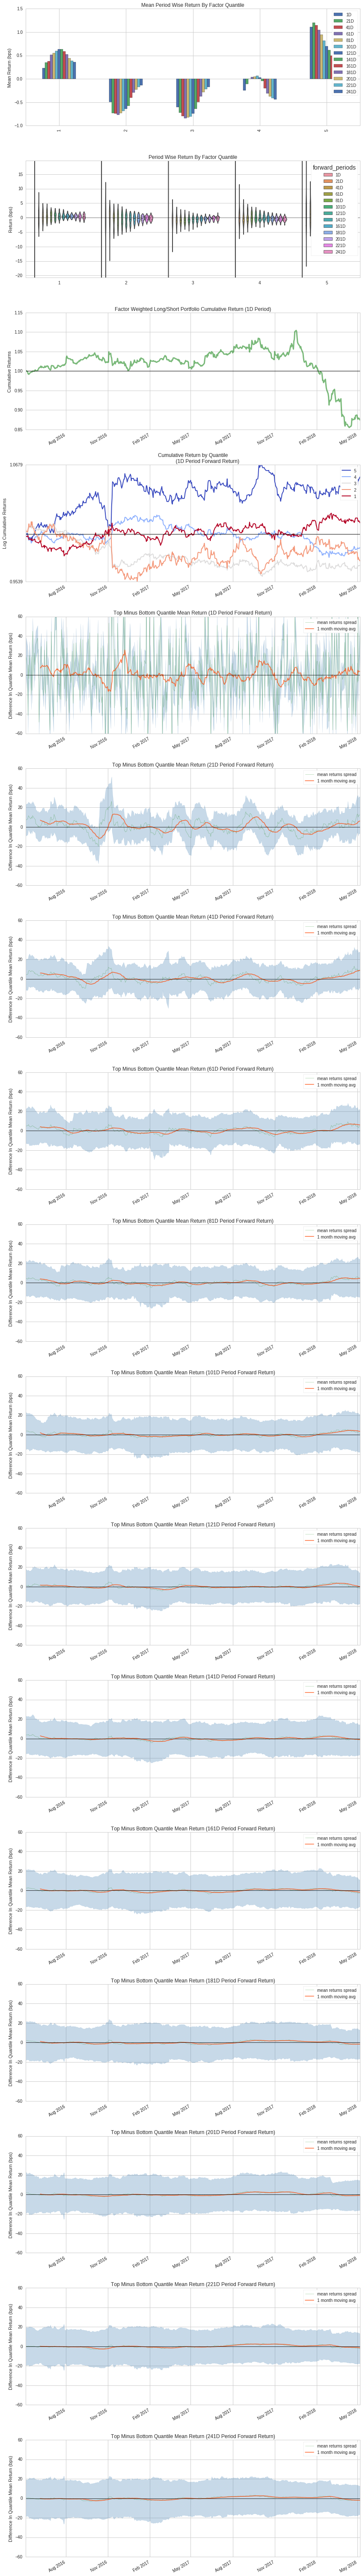

In [100]:
create_returns_tear_sheet(factor_merged_data)

The most predictive are style_score and style_value factors. Actually, style_score is computed as a difference between growth_score and value_score, so it is a little bit strange to include value_score factor to the style_score one. So we will go with style_score as a winner! 

So our analysis conclude that factor based on market anomaly (value premium stocks) has predictive power for long/short strategy. (for period from 2016-05-05 to 2018-05-05)

## Surprise 
Quantopian provides FactSet Estimates - Consensus (a global dataset that provides insights based on broker reports aggregated into a daily consensus estimate value.) and FactSet Estimates - Actuals (actual values provided through statements)

There is a popular kind of mean reversion strategy: if we see that our estimates is lower than actual reported values - it is a call for the long bet, and vice versa. So our factor here is an insight from "expectation vs reality" thing.

In [146]:
def make_pipeline():
    
    fq0_eps_cons = PeriodicConsensus.slice('EPS', 'qf', 0)
    fq0_eps_act = Actuals.slice('EPS', 'qf', 0)
 
    # Define factors of the last mean consensus EPS estimate and actual EPS.
    fq0_eps_cons_mean = fq0_eps_cons.mean.latest
    fq0_eps_act_value = fq0_eps_act.actual_value.latest
 
    # Define a surprise factor as the relative difference between the actual EPS and the final 
    # mean estimate made prior to the report being published. A positive value means the company
    # beat analyst expectations. A negative value means the company missed expectations.
    surprise_percentage = (fq0_eps_act_value - fq0_eps_cons_mean) / fq0_eps_cons_mean
    
    return Pipeline(
        columns={
            'surprise_percentage': surprise_percentage
            
        },
        screen=QTradableStocksUS() 
    )

In [147]:
# Run the pipeline over a year and print the result.
factor_data = run_pipeline(make_pipeline(), '2016-05-05', '2018-05-05')

In [148]:
pricing_data = get_pricing(factor_data.index.levels[1], '2016-05-05', '2019-05-05', fields='open_price')

In [150]:
longest_look_forward_period = 252 # week = 5, month = 21, quarter = 63, year = 252
range_step = 20

factor_merged_data = get_clean_factor_and_forward_returns(
        factor_data['surprise_percentage'], # How to analyze a specific pipeline column with Alphalens
        pricing_data, 
        periods=range(1,longest_look_forward_period,range_step))
    

Dropped 6.5% entries from factor data: 6.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


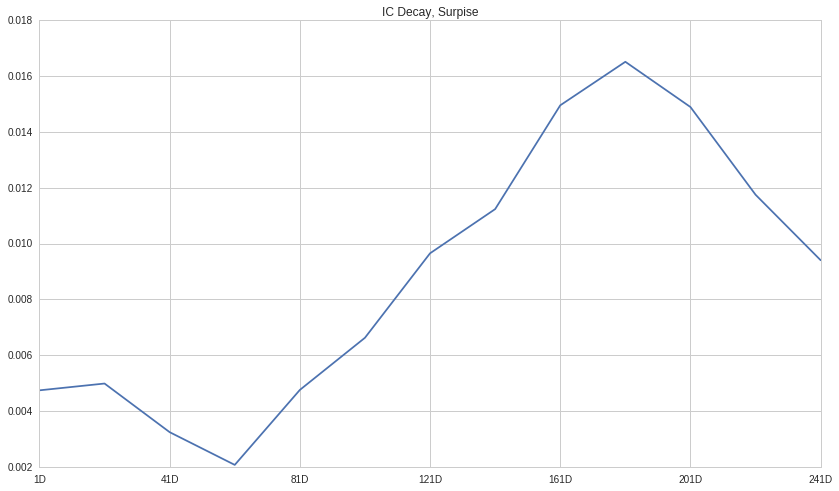

In [153]:
mean_information_coefficient(factor_merged_data).plot(title='IC Decay, Surpise')

Returns Analysis


1D    21D    41D    61D  \
Ann. alpha                                     0.025 -0.015 -0.040 -0.052   
beta                                          -0.078  0.014  0.137  0.212   
Mean Period Wise Return Top Quantile (bps)    -0.143 -0.188 -0.073  0.039   
Mean Period Wise Return Bottom Quantile (bps) -0.318 -0.269 -0.350 -0.284   
Mean Period Wise Spread (bps)                  0.175  0.085  0.276  0.325   

                                                 81D   101D   121D   141D  \
Ann. alpha                                    -0.047 -0.026 -0.007 -0.003   
beta                                           0.273  0.226  0.159  0.166   
Mean Period Wise Return Top Quantile (bps)     0.208  0.326  0.432  0.477   
Mean Period Wise Return Bottom Quantile (bps) -0.369 -0.344 -0.363 -0.346   
Mean Period Wise Spread (bps)                  0.582  0.678  0.803  0.836   

                                                161D   181D   201D   221D  \
Ann. alpha                                     0.001 -0.001 -0.014 -0.040   
beta                                           0.164  0.217  0.299  0.492   
Mean Period Wise Return Top Quantile (bps)     0.532  0.517  0.416  0.264   
Mean Period Wise Return Bottom Quantile (bps) -0.402 -0.388 -0.323 -0.247   
Mean Period Wise Spread (bps)                  0.949  0.919  0.752  0.521   

                                                241D  
Ann. alpha                                    -0.055  
beta                                           0.618  
Mean Period Wise Return Top Quantile (bps)     0.127  
Mean Period Wise Return Bottom Quantile (bps) -0.214  
Mean Period Wise Spread (bps)                  0.349

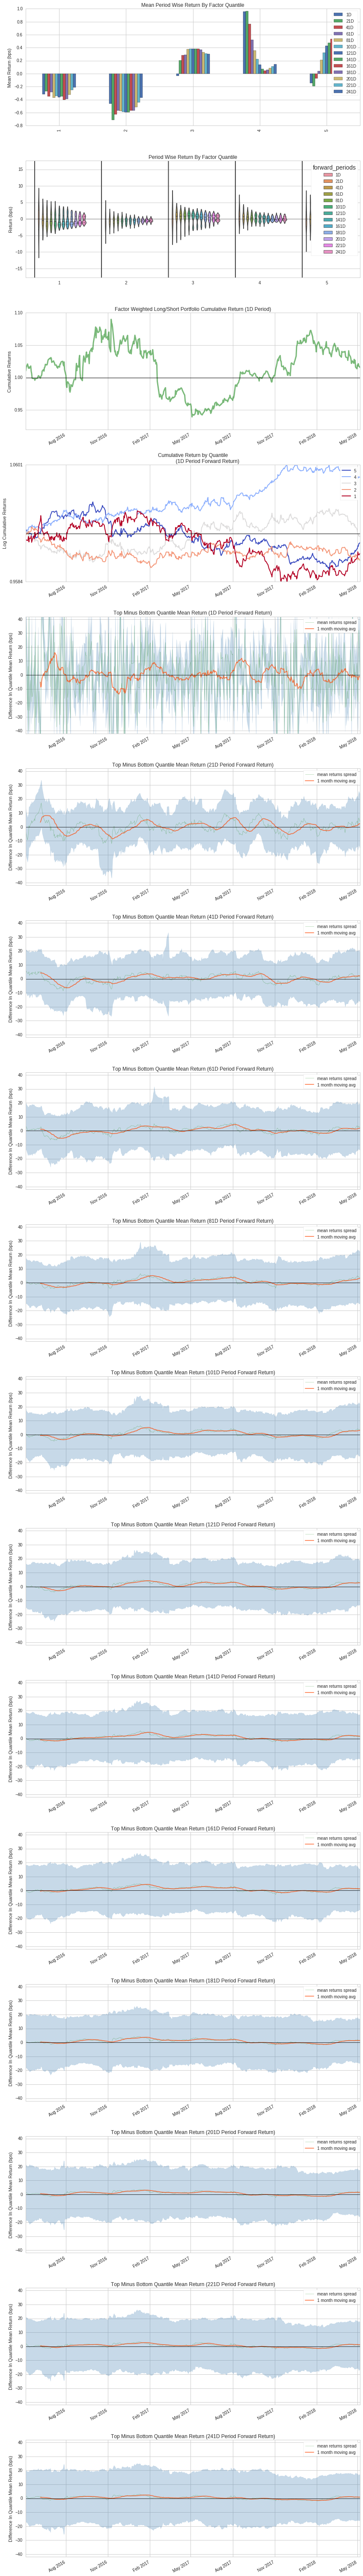

In [154]:
create_returns_tear_sheet(factor_merged_data)

Surprise as only factor is a little bit bad choice. We can see that 4th quantile is much better that a 5th one. So we won't include it as is in our final factor. Although I am personally very insterested in idea that we use such information from trading. I will consider an approach were we can use surprise with several changes in order to construct our long/short pretendents

### For the last part, we will take a glance on the winners from all the factors and compare them in group neutral approach

After first iteration I crossed out "market cap and price to book" and combined_factor_2 due to analysis

We will consider:
- momentum_month
- momentum_quarter
- style
- combinations of those

In [164]:
def make_pipeline():
    
    momentum_month = MomentumM()
    momentum_quarter = MomentumQ()
   
    style_score = Fundamentals.style_score.latest
    
    momentumM_and_style = momentum_month.zscore() + style_score.zscore()
    momentumQ_and_style = momentum_quarter.zscore() + style_score.zscore()
    
    
    return Pipeline(
        columns={
            'momentum_month': momentum_month,
            'momentum_quarter': momentum_quarter,
            'style_score': style_score,
            'momentum_month_and_style': momentumM_and_style,
            'momentum_quarter_and_style': momentumQ_and_style
        },
        screen=QTradableStocksUS() 
    )

# Run the pipeline over a year and print the result.
factor_data = run_pipeline(make_pipeline(), '2016-05-05', '2018-05-05')
pricing_data = get_pricing(factor_data.index.levels[1], '2016-05-05', '2019-05-05', fields='open_price')

In [165]:
longest_look_forward_period = 252 # week = 5, month = 21, quarter = 63, year = 252
range_step = 20

factor_names = ['momentum_month', 'momentum_quarter', 'style_score',
               'momentum_month_and_style', 'momentum_quarter_and_style']

factor_merged_data_list = []

for factor_name in factor_names:
    
    print("Computing forward returns for: ", factor_name, '\n')
    
    factor_merged_data = get_clean_factor_and_forward_returns(
        factor_data[factor_name], # How to analyze a specific pipeline column with Alphalens
        pricing_data, 
        periods=range(1,longest_look_forward_period,range_step))
    
    factor_merged_data_list.append(factor_merged_data)

Computing forward returns for:  momentum_month 

Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  momentum_quarter 

Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  style_score 

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing forward returns for:  momentum_month_and_style 

Dropped 6.9% entries from factor data: 6.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computi

In [166]:
mean_ic_list = []

for factor_name, factor_merged_data in zip(factor_names, factor_merged_data_list):
    
    print('Computing mean IC for: ' + factor_name)
    factor_mean_information_coefficient = mean_information_coefficient(factor_merged_data)
    mean_ic_list.append(factor_mean_information_coefficient.values)

inds = range(1,longest_look_forward_period,range_step)

Computing mean IC for: momentum_month
Computing mean IC for: momentum_quarter
Computing mean IC for: style_score
Computing mean IC for: momentum_month_and_style
Computing mean IC for: momentum_quarter_and_style


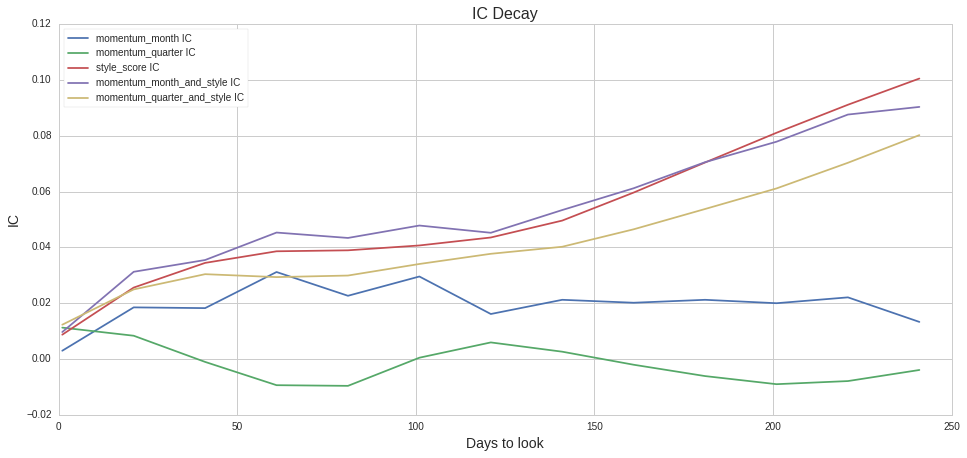

In [167]:
plt.figure(figsize=(16, 7))

for factor_name, factor_mean_ic in zip(factor_names, mean_ic_list):
    plt.plot(inds, factor_mean_ic, label=factor_name + ' IC')
    

plt.legend(loc='upper left')
plt.xlabel("Days to look", size=14)
plt.ylabel('IC', size=14)
plt.title('IC Decay', size=16)
plt.show();

Factor  momentum_quarter_and_style
Returns Analysis


1D    21D    41D    61D  \
Ann. alpha                                     0.051  0.069  0.078  0.081   
beta                                           0.033 -0.168 -0.251 -0.293   
Mean Period Wise Return Top Quantile (bps)     2.776  2.065  1.995  1.927   
Mean Period Wise Return Bottom Quantile (bps) -1.669 -0.650 -0.614 -0.538   
Mean Period Wise Spread (bps)                  4.445  2.698  2.585  2.432   

                                                 81D   101D   121D   141D  \
Ann. alpha                                     0.090  0.115  0.115  0.094   
beta                                          -0.350 -0.472 -0.477 -0.378   
Mean Period Wise Return Top Quantile (bps)     2.011  2.272  2.367  2.347   
Mean Period Wise Return Bottom Quantile (bps) -0.551 -0.689 -0.754 -0.684   
Mean Period Wise Spread (bps)                  2.531  2.929  3.096  3.006   

                                                161D   181D   201D   221D  \
Ann. alpha                                     0.063  0.047  0.043  0.044   
beta                                          -0.182 -0.055 -0.012  0.005   
Mean Period Wise Return Top Quantile (bps)     2.392  2.443  2.495  2.593   
Mean Period Wise Return Bottom Quantile (bps) -0.806 -0.962 -1.106 -1.269   
Mean Period Wise Spread (bps)                  3.177  3.383  3.582  3.850   

                                                241D  
Ann. alpha                                     0.051  
beta                                          -0.023  
Mean Period Wise Return Top Quantile (bps)     2.680  
Mean Period Wise Return Bottom Quantile (bps) -1.411  
Mean Period Wise Spread (bps)                  4.081

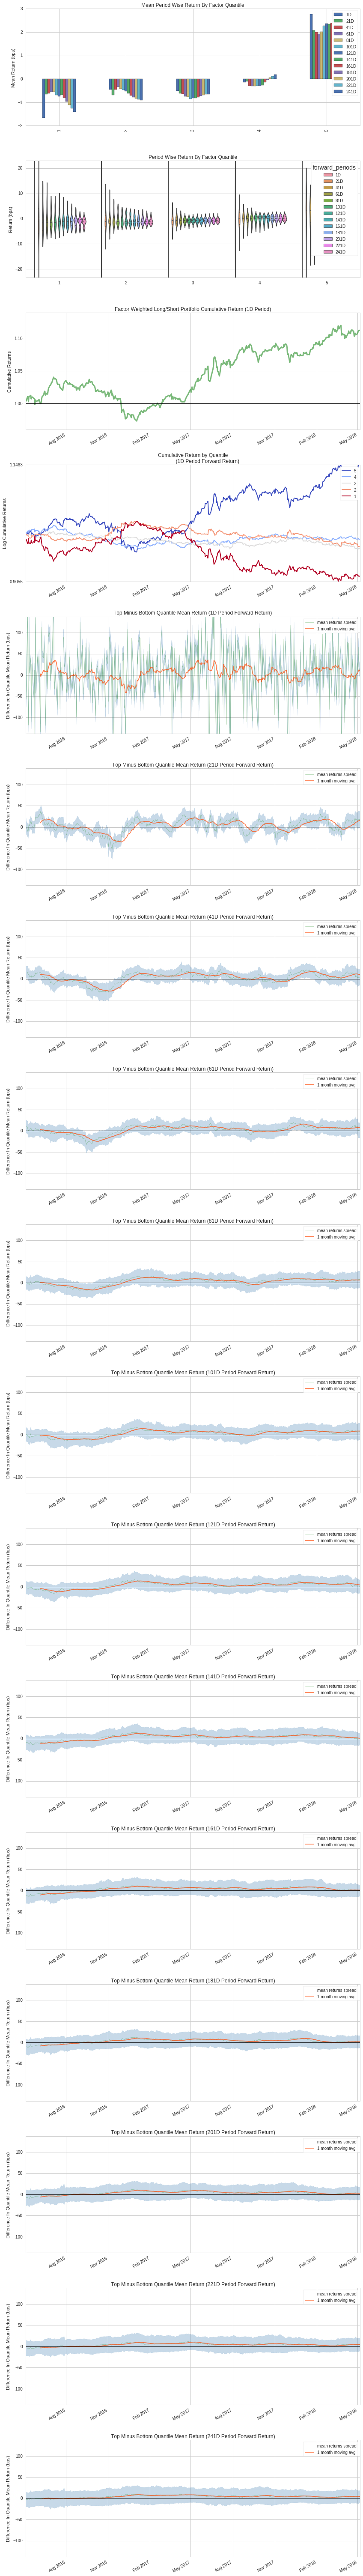

In [172]:
# style_score, value_style_scores
key = 4
factor_merged_data = factor_merged_data_list[key]
print('Factor ', factor_names[key])
create_returns_tear_sheet(factor_merged_data)

Bonus: lets look on very important factor earnings per share (EPS) and its combination with winner factors

In [187]:
def make_pipeline():
    
    momentum_quarter = MomentumQ()
   
    style_score = Fundamentals.style_score.latest
    
    basic_eps = Fundamentals.basic_eps_earnings_reports.latest
    momentumQ_and_eps = momentum_quarter.zscore() + basic_eps.zscore()
    momentumQ_eps_and_style = momentum_quarter.zscore() + style_score.zscore() + basic_eps.zscore()
    
    return Pipeline(
        columns={
            'basic_eps': basic_eps,
            'momentumQ_and_eps': momentumQ_and_eps,
            'momentumQ_eps_and_style': momentumQ_eps_and_style
        },
        screen=QTradableStocksUS() 
    )

# Run the pipeline over a year and print the result.
factor_data = run_pipeline(make_pipeline(), '2016-05-05', '2018-05-05')
pricing_data = get_pricing(factor_data.index.levels[1], '2016-05-05', '2019-05-05', fields='open_price')

longest_look_forward_period = 252 # week = 5, month = 21, quarter = 63, year = 252
range_step = 20

factor_names = ['momentumQ_eps_and_style']

factor_merged_data_list = []

for factor_name in factor_names:
    
    print("Computing forward returns for: ", factor_name, '\n')
    
    factor_merged_data = get_clean_factor_and_forward_returns(
        factor_data[factor_name], # How to analyze a specific pipeline column with Alphalens
        pricing_data, 
        periods=range(1,longest_look_forward_period,range_step))
    
    factor_merged_data_list.append(factor_merged_data)
    
mean_ic_list = []

for factor_name, factor_merged_data in zip(factor_names, factor_merged_data_list):
    
    print('Computing mean IC for: ' + factor_name)
    factor_mean_information_coefficient = mean_information_coefficient(factor_merged_data)
    mean_ic_list.append(factor_mean_information_coefficient.values)

inds = range(1,longest_look_forward_period,range_step)

Computing forward returns for:  momentumQ_eps_and_style 

Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Computing mean IC for: momentumQ_eps_and_style


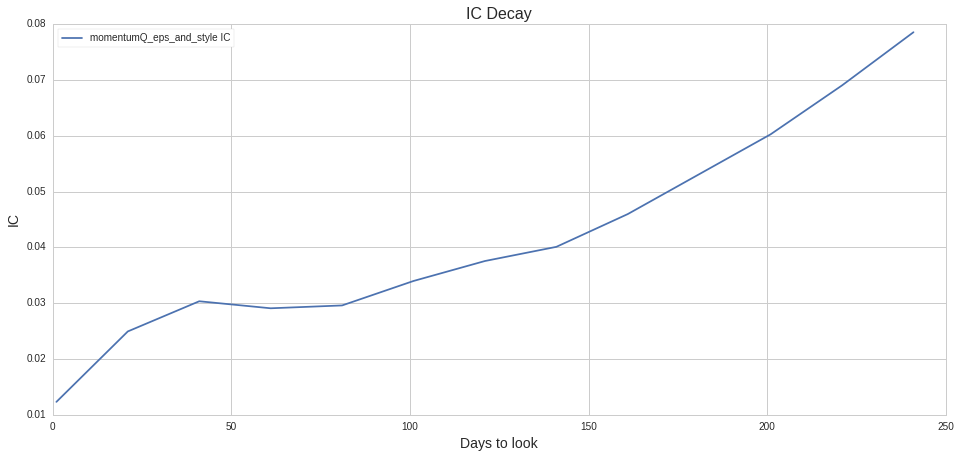

In [188]:
plt.figure(figsize=(16, 7))

for factor_name, factor_mean_ic in zip(factor_names, mean_ic_list):
    plt.plot(inds, factor_mean_ic, label=factor_name + ' IC')
    

plt.legend(loc='upper left')
plt.xlabel("Days to look", size=14)
plt.ylabel('IC', size=14)
plt.title('IC Decay', size=16)
plt.show();

Factor  momentumQ_eps_and_style
Returns Analysis


1D    21D    41D    61D  \
Ann. alpha                                     0.051  0.069  0.078  0.081   
beta                                           0.033 -0.166 -0.248 -0.291   
Mean Period Wise Return Top Quantile (bps)     2.751  2.046  1.970  1.898   
Mean Period Wise Return Bottom Quantile (bps) -1.671 -0.661 -0.627 -0.553   
Mean Period Wise Spread (bps)                  4.422  2.689  2.573  2.416   

                                                 81D   101D   121D   141D  \
Ann. alpha                                     0.090  0.114  0.115  0.094   
beta                                          -0.346 -0.464 -0.476 -0.377   
Mean Period Wise Return Top Quantile (bps)     1.985  2.240  2.335  2.319   
Mean Period Wise Return Bottom Quantile (bps) -0.565 -0.706 -0.764 -0.692   
Mean Period Wise Spread (bps)                  2.517  2.914  3.074  2.987   

                                                161D   181D   201D   221D  \
Ann. alpha                                     0.062  0.046  0.043  0.043   
beta                                          -0.172 -0.046 -0.007  0.009   
Mean Period Wise Return Top Quantile (bps)     2.360  2.417  2.478  2.577   
Mean Period Wise Return Bottom Quantile (bps) -0.805 -0.953 -1.089 -1.242   
Mean Period Wise Spread (bps)                  3.146  3.350  3.549  3.808   

                                                241D  
Ann. alpha                                     0.050  
beta                                          -0.020  
Mean Period Wise Return Top Quantile (bps)     2.662  
Mean Period Wise Return Bottom Quantile (bps) -1.379  
Mean Period Wise Spread (bps)                  4.033

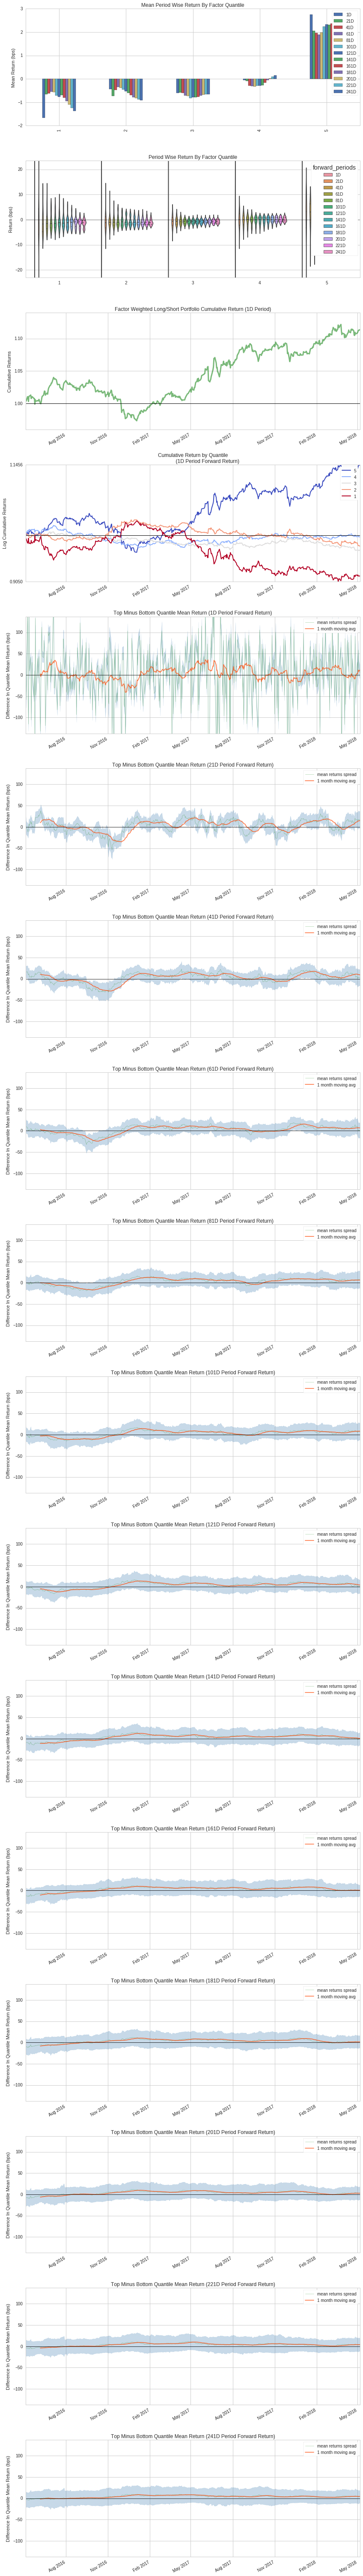

In [189]:
# style_score, value_style_scores
key = 0
factor_merged_data = factor_merged_data_list[key]
print('Factor ', factor_names[key])
create_returns_tear_sheet(factor_merged_data)

## Results
Combination of the style_score and momentum_quarter gives the best results based on our analysis. If we include EPs to our combine factors, predictive power doesn't go down, but from those plots we can't really say that results are better.

This notebooks provides analysis of predictive power of different factors. Criterias of such a claim are:
- information coficient
- Mean Period wise Return By Factor Quantile
- Cumulative Return by Quantile
- Perfomance of quantiles in expected way (small amount of quantiles lines crossings and more importantly 1st quantile should have the lowest returns and 5st quantile - the highest one)